In [52]:
import os
os.environ["JAVA_HOME"] = "/usr"

In [53]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.12").config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven").getOrCreate()

df = spark.sql("Select 'spark' as hello ")

df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



# Data Preparation

### Data loading

In [54]:
train_df = spark.read.parquet("../data/processed/Base_train.parquet", header=True, inferSchema=True)
train_df.show()

+--------------------+-----+----------+
|            features|label|        id|
+--------------------+-----+----------+
|[0.18046796286410...|    0|8589934592|
|[1.20884843553557...|    0|8589934593|
|[0.86605494464508...|    0|8589934594|
|[0.52326145375459...|    0|8589934595|
|[0.86605494464508...|    0|8589934596|
|[0.52326145375459...|    0|8589934597|
|[0.86605494464508...|    0|8589934598|
|[-1.1907060006978...|    0|8589934599|
|[0.52326145375459...|    0|8589934600|
|[0.18046796286410...|    0|8589934601|
|[1.20884843553557...|    0|8589934602|
|[1.20884843553557...|    0|8589934603|
|[0.86605494464508...|    0|8589934604|
|[0.86605494464508...|    0|8589934605|
|[0.86605494464508...|    0|8589934606|
|[0.86605494464508...|    0|8589934607|
|[-1.1907060006978...|    0|8589934608|
|[1.20884843553557...|    0|8589934609|
|[0.86605494464508...|    0|8589934610|
|[1.20884843553557...|    0|8589934611|
+--------------------+-----+----------+
only showing top 20 rows


In [55]:
feats_df = spark.read.parquet("../data/processed/Base_train_feats.parquet", header=True, inferSchema=True)
feats_df.show()

+-----+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+----------+
|label|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_count|has_other_cards|

In [56]:
df = train_df.join(feats_df, "id")

In [57]:
test_df = spark.read.parquet("../data/processed/Base_test.parquet", header=True, inferSchema=True)
test_df.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+-----+------------+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_coun

### Test df processing

In [58]:
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col

pipe = PipelineModel.load("../models/processing_pipeline")
test_df_processed = test_df.drop("month")

test_df_processed = pipe.transform(test_df_processed)

test_df_processed = test_df_processed.select(col('scaled_features').alias('features'), col('fraud_bool').alias('label'), col("id"))
test_df_processed.show(1, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+------------+
|features                                                                    

### Fairness DF Creation

To evaluate fariness we will create a dataframe with some sensitive features

In [59]:
test_pdf = test_df.toPandas()
test_pdf

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,id
0,0,0.8,0.502961,13,14,30,0.031699,-0.504518,AC,1011,...,0,1000.0,0,INTERNET,5.245903,other,1,1,6,240518168576
1,0,0.1,0.231473,0,112,40,0.002116,-1.755836,AB,1012,...,0,200.0,0,INTERNET,56.568777,macintosh,0,1,6,240518168577
2,0,0.9,0.890015,0,47,60,0.039205,-1.236018,AA,1159,...,0,200.0,0,INTERNET,28.016203,other,1,1,6,240518168578
3,0,0.8,0.052898,30,9,20,0.039805,-1.435753,AD,289,...,0,500.0,0,INTERNET,3.605017,windows,0,1,6,240518168579
4,0,0.9,0.752483,0,46,20,0.006882,49.195335,AA,779,...,0,200.0,0,INTERNET,1.350371,other,1,1,6,240518168580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205006,0,0.8,0.175288,331,1,40,0.002657,-0.458843,AA,318,...,0,1500.0,0,INTERNET,2.828575,windows,0,1,6,206158431829
205007,0,0.8,0.999338,0,285,20,0.004945,-0.540756,AC,2588,...,1,200.0,0,INTERNET,4.869606,linux,0,1,6,206158431830
205008,0,0.4,0.823836,0,46,20,0.001346,48.718399,AA,952,...,1,200.0,0,INTERNET,1.301001,linux,1,1,6,206158431831
205009,0,0.6,0.331495,0,85,30,0.013632,17.611195,AA,999,...,1,200.0,0,INTERNET,4.116756,windows,1,1,6,206158431832


In [60]:
pdf_fairness = test_pdf[["id", "customer_age", "foreign_request"]]
pdf_fairness

,id,customer_age,foreign_request
0,240518168576,30,0
1,240518168577,40,0
2,240518168578,60,0
3,240518168579,20,0
4,240518168580,20,0
...,...,...,...
205006,206158431829,40,0
205007,206158431830,20,0
205008,206158431831,20,0
205009,206158431832,30,0


In [61]:
def age_group(x):
    if x < 18:
        return "Adolescent"
    if x < 25:
        return "Young Adult"
    if x < 60:
        return "Adult"
    return "Elderly"

pdf_fairness = pdf_fairness.copy()
pdf_fairness["age_group"] = pdf_fairness["customer_age"].map(age_group).astype("category")
pdf_fairness['foreign_request'] = pdf_fairness['foreign_request'].replace({0: "Not Foreign", 1: "Foreign"}).astype("category")
pdf_fairness = pdf_fairness.drop("customer_age", axis=1)
pdf_fairness

,id,foreign_request,age_group
0,240518168576,Not Foreign,Adult
1,240518168577,Not Foreign,Adult
2,240518168578,Not Foreign,Elderly
3,240518168579,Not Foreign,Young Adult
4,240518168580,Not Foreign,Young Adult
...,...,...,...
205006,206158431829,Not Foreign,Adult
205007,206158431830,Not Foreign,Young Adult
205008,206158431831,Not Foreign,Young Adult
205009,206158431832,Not Foreign,Adult


# XGBoost

Let's first experiment with a vanilla xgboost

In [62]:
model_name = "xgb_fraud_detection_v1_0"

In [63]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import DataFrame
import xgboost as xgb
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import logging
import json
import os


def calculate_scale_pos_weight(train_df: DataFrame) -> float:
    """Calculate class imbalance ratio for scale_pos_weight"""
    class_counts = train_df.groupBy('label').count().collect()
    count_dict = {row['label']: row['count'] for row in class_counts}
    return count_dict[0] / count_dict[1]  # non-fraud / fraud

def objective(trial: Trial, train_df: DataFrame, test_df: DataFrame, scale_pos_weight: float) -> float:
    """Optuna objective function to maximize AUPRC"""
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    xgb_classifier = SparkXGBClassifier(
        features_col='features',
        label_col='label',
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',
        num_workers=4,
        verbosity=0,
        **params
    )
    
    model = xgb_classifier.fit(train_df)
    predictions = model.transform(test_df)
    
    evaluator = BinaryClassificationEvaluator(
        labelCol='label',
        rawPredictionCol='rawPrediction',
        metricName='areaUnderPR'
    )
    
    auprc = evaluator.evaluate(predictions)
    return auprc

def train_model(train_df: DataFrame, test_df: DataFrame, model_name: str, n_trials: int = 50) -> tuple[SparkXGBClassifier, dict, float]:
    """
    Train XGBoost model with Optuna hyperparameter optimization
    Returns: (best_model, best_params, best_auprc)
    """
    scale_pos_weight = calculate_scale_pos_weight(train_df)
    
    best_params_path = f"../models/{model_name}_best_params.json"
    if not os.path.exists(best_params_path):
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42)
        )
        
        # wrap the objective function with fixed arguments
        func = lambda trial: objective(trial, train_df, test_df, scale_pos_weight)
        
        study.optimize(func, n_trials=n_trials)
        
        # Train final model with best parameters
        best_params = study.best_params
        with open(best_params_path, "w") as f:
            json.dump(best_params,f, indent=4)
    
    with open(best_params_path) as f:
        best_params = json.load(f)

    xgb_classifier = SparkXGBClassifier(
        features_col='features',
        label_col='label',
        scale_pos_weight=scale_pos_weight,
        eval_metric='aucpr',
        num_workers=4,
        verbosity=1,
        **best_params
    )
    
    best_model = xgb_classifier.fit(train_df)
    
    # Evaluate on test set
    predictions = best_model.transform(test_df)
    evaluator = BinaryClassificationEvaluator(
        labelCol='label',
        rawPredictionCol='rawPrediction',
        metricName='areaUnderPR'
    )
    best_auprc = evaluator.evaluate(predictions)
    
    return best_model, best_params, best_auprc

def make_predictions(xgb_model: SparkXGBClassifier, test_df: DataFrame) -> DataFrame:
    """Make predictions using the trained model"""
    predictions = xgb_model.transform(test_df)
    return predictions


def evaluate_model(predictions):
    """
    Evaluate the performance of a trained XGBoost model and display metrics.
    
    Args:
        predictions: Spark DataFrame containing model predictions
        xgb_model: Trained XGBoost model object
        model_save_path: (optional) Path to save the model. If None, model won't be saved.
    
    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    roc_evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="probability",
        labelCol="label",
        metricName="areaUnderROC"
    )
    auc = roc_evaluator.evaluate(predictions)

    pr_evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="probability",
        labelCol="label",
        metricName="areaUnderPR"
    )
    aupr = pr_evaluator.evaluate(predictions)

    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )
    f1 = multi_evaluator.evaluate(predictions)

    print(f"Test AUC: {auc:.4f}")
    print(f"Test AUPR: {aupr:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    
    metrics = {
        'auc': auc,
        'aupr': aupr,
        'f1': f1,
    }
    
    return metrics
    

In [64]:
xgb_model, best_params, best_aucpr = train_model(train_df, test_df_processed, model_name)

2025-07-29 05:17:07,365 INFO XGBoost-PySpark: _fit Running xgboost-3.0.2 on 4 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.7705077049207281, 'device': 'cpu', 'eval_metric': 'aucpr', 'gamma': 0.6138262892618663, 'learning_rate': 0.1355924526646326, 'max_depth': 3, 'min_child_weight': 8, 'reg_alpha': 0.5804793928477672, 'reg_lambda': 0.17671504264721596, 'scale_pos_weight': 96.53269537480064, 'subsample': 0.9789615757323006, 'verbosity': 1, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 177}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-07-29 05:17:09,338 INFO XGBoost-PySpark: _train_booster Training on CPUs 4]
[05:17:10] Task 0 got rank 0[05:17:10] Task 1 got rank 1[05:17:10] Task 2 got rank 2[05:17:10] Task 3 got rank 3



[05:17:11] [0]	training-aucpr:0.04710
[05:17:11] [1]	training-aucpr:0.04817
[05:17:11] [2]	training-aucpr:0.05790
[05:17:11] [3]	training-aucpr:0.06307
[05:17:11] [4]	training-aucpr:0.

In [65]:
predictions = make_predictions(xgb_model, test_df_processed)

In [66]:
predictions.show(5)

+--------------------+-----+------------+--------------------+----------+--------------------+
|            features|label|          id|       rawPrediction|prediction|         probability|
+--------------------+-----+------------+--------------------+----------+--------------------+
|[0.86605494464508...|    0|240518168576|[2.92565608024597...|       0.0|[0.94910025596618...|
|[-1.5334994915883...|    0|240518168577|[-0.7727064490318...|       1.0|[0.31589394807815...|
|[1.20884843553557...|    0|240518168578|[2.13984680175781...|       0.0|[0.89471620321273...|
|[0.86605494464508...|    0|240518168579|[0.87860780954360...|       0.0|[0.70653367042541...|
|[1.20884843553557...|    0|240518168580|[1.87006783485412...|       0.0|[0.86646616458892...|
+--------------------+-----+------------+--------------------+----------+--------------------+
only showing top 5 rows


2025-07-29 05:17:18,066 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [67]:
metrics = evaluate_model(predictions)
metrics

Exception ignored in: <_io.BufferedWriter name=7>
Traceback (most recent call last):
  File "/home/matheus/Documents/Projects/PersonalProjects/fraud-detection/.venv/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 200, in manager
BrokenPipeError: [Errno 32] Broken pipe
2025-07-29 05:17:19,081 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-07-29 05:17:19,506 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-07-29 05:17:20,246 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


Test AUC: 0.8957
Test AUPR: 0.1943
Test F1 Score: 0.8841


{'auc': 0.895681882122576,
 'aupr': 0.1943341766104821,
 'f1': 0.8841424063706734}

In [68]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

extract_first_prob = udf(lambda v: float(v[0]), FloatType())

# separate prob column
predictions = predictions.withColumn(
    "prob_class_0", extract_first_prob("probability")
).withColumn("prob_class_1", 1 - col("prob_class_0"))

results_pdf = predictions.select(["label", "prediction", col("prob_class_1").alias("probability"), "id"]).toPandas()
results_pdf

2025-07-29 05:17:20,749 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


,label,prediction,probability,id
0,0,0.0,0.050900,240518168576
1,0,1.0,0.684106,240518168577
2,0,0.0,0.105284,240518168578
3,0,0.0,0.293466,240518168579
4,0,0.0,0.133534,240518168580
...,...,...,...,...
205006,0,1.0,0.693537,206158431829
205007,0,0.0,0.067449,206158431830
205008,0,0.0,0.011185,206158431831
205009,0,0.0,0.142889,206158431832


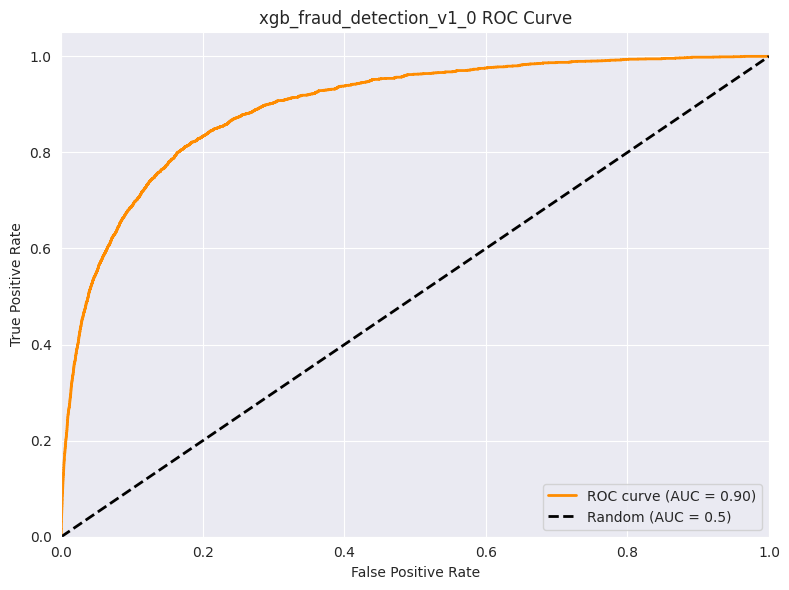

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from pathlib import Path

PLOT_SAVE_DIR = Path("../reports/figures/model-training")
PLOT_SAVE_DIR.mkdir(parents=True, exist_ok=True)

y_true = results_pdf['label']
y_pred = results_pdf['prediction']
y_prob = results_pdf['probability']
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{model_name} ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(PLOT_SAVE_DIR / f"{model_name}_roc.png")
plt.show()

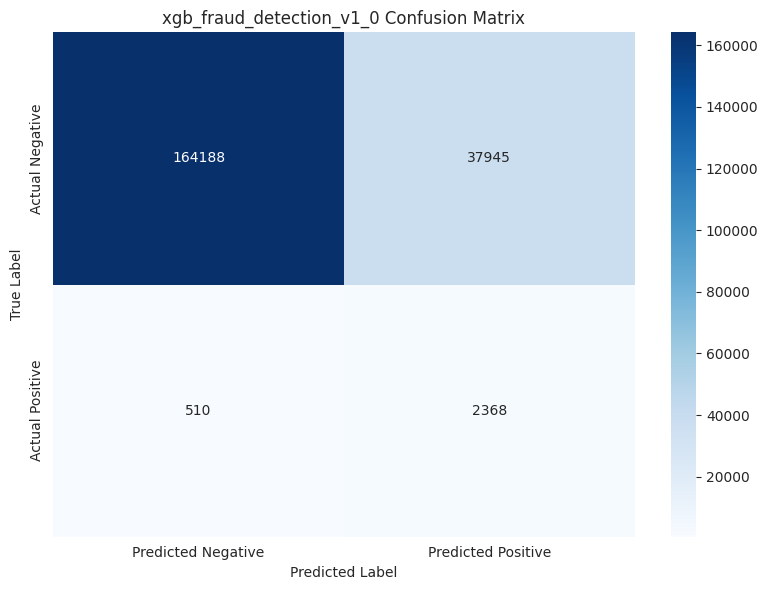

In [70]:
sns.set_style("darkgrid")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{model_name} Confusion Matrix')
plt.tight_layout()
plt.savefig(PLOT_SAVE_DIR / f"{model_name}_cm.png")
plt.show()

In [71]:
xgb_model_native: xgb.Booster = xgb_model.get_booster()

importances = xgb_model_native.get_score(importance_type='weight')
print("\nTop 10 Features by Weight:")
for feature, weight in sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"Feature {feature}: {weight:.4f}")


Top 10 Features by Weight:
Feature f3: 82.0000
Feature f1: 81.0000
Feature f11: 74.0000
Feature f13: 72.0000
Feature f10: 69.0000
Feature f5: 62.0000
Feature f6: 59.0000
Feature f7: 54.0000
Feature f0: 50.0000
Feature f9: 45.0000


Let's save the model for future use

In [73]:
import shutil
import os
xgb_model_native.save_model(f"../models/{model_name}.json")

model_path_spark = f"../models/{model_name}.spark"

if os.path.exists(model_path_spark):
    shutil.rmtree(model_path_spark)

xgb_model.save(model_path_spark)

### Fairness Evaluation

In [74]:
import pandas as pd


new_fairness_df = results_pdf.join(pdf_fairness, how='left', rsuffix='_right').drop(columns=["id_right"])
y_test = new_fairness_df["label"]
y_pred = new_fairness_df["prediction"]
sensitive_features = new_fairness_df[["foreign_request", "age_group"]]

In [75]:
from fairlearn.metrics import MetricFrame, equalized_odds_ratio, selection_rate, false_positive_rate, count
from sklearn.metrics import fbeta_score
import functools

fbeta_14 = functools.partial(fbeta_score, beta=1.4, zero_division=1)
eq_odds_ratio = functools.partial(equalized_odds_ratio, sensitive_features=sensitive_features)

metrics = {
    "Selection Rate": selection_rate,
    "F Beta 1.4": fbeta_14,
    #"Equalized Odds Ratio": eq_odds_ratio,
    "False Positive Rate": false_positive_rate,
    "counts": count
}

grouped_sensitive_features = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)
grouped_sensitive_features.overall

Selection Rate              0.196638
F Beta 1.4                  0.152529
False Positive Rate         0.187723
counts                 205011.000000
dtype: float64

In [76]:
grouped_sensitive_features.by_group

Selection Rate  F Beta 1.4  False Positive Rate  \
foreign_request age_group                                                      
Foreign         Adolescent         0.152778    0.000000             0.154930   
                Adult              0.335390    0.206064             0.317921   
                Elderly            0.507937    0.431613             0.452381   
                Young Adult        0.171773    0.111467             0.166510   
Not Foreign     Adolescent         0.074841    0.085147             0.072756   
                Adult              0.217563    0.146620             0.208417   
                Elderly            0.418246    0.234715             0.395327   
                Young Adult        0.095087    0.113981             0.091530   

                               counts  
foreign_request age_group              
Foreign         Adolescent       72.0  
                Adult          3241.0  
                Elderly         189.0  
                Young Adult    1077.0  
Not Foreign     Adolescent     5024.0  
                Adult        142230.0  
                Elderly        7914.0  
                Young Adult   45264.0

# Wrapping up

We trained our model and evaluated it, looking into its fairness too. The model performance is not good enough, but we only experimented with one model. For the next steps, we will test our model in the test set.